In [587]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
from random import random
pd.set_option('display.max_columns', None)

df = pd.read_csv('train.csv')
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## Variable Description¶
PassengerId : unique id number to each passenger
Survived: passenger survived (1), died (0)
Pclass: passenger class
Name: passenger name
Sex: gender of passenger
Age: age of passenger
SibSp: number of siblings and children
Parch: number of parents and children
Ticket: ticket number
Fare: amount of money that spent on ticket
Cabin: cabin number
Embarked: oırt where passenger embarked (C = Cherbourg, Q = Queenstown, S = Couthampton)

In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [602]:
df.loc[~df.Cabin.isna(),['Cabin','Survived']].groupby(['Cabin'],as_index=False).count()

,Cabin,Survived
0,A10,1
1,A14,1
2,A16,1
3,A19,1
4,A20,1
...,...,...
142,F33,3
143,F38,1
144,F4,2
145,G6,4


In [598]:
df.loc[~df.SibSp.isna(),['SibSp','Survived']].groupby(['SibSp'],as_index=False).mean()

,SibSp,Survived
0,0,0.611111
1,1,0.753623
2,2,0.833333
3,3,0.666667


In [581]:
df['Sex'] = [1 if item=='male' else 0 for item in df.Sex]
df['Age'] = df['Age'].fillna(np.mean(df['Age']))
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked')
df = pd.get_dummies(df, columns=['SibSp'], prefix='SibSp')
df = pd.get_dummies(df, columns=['Parch'], prefix='Parch')
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
886,887,0,2,"Montvila, Rev. Juozas",1,27.000000,211536,13.00,NaN,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.000000,112053,30.00,B42,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29.699118,W./C. 6607,23.45,NaN,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",1,26.000000,111369,30.00,C148,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
890,891,0,3,"Dooley, Mr. Patrick",1,32.000000,370376,7.75,NaN,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [582]:
y = ['Survived']
X = [col for col in df.columns if col not in ['PassengerId','Survived','Name','Ticket','Cabin','Parch','SibSp']]
TEST_AMOUNT = 0.2
EXCLUDE_OUTLIERS = True
print(f'X:{X}\ny:{y}\nTest set:{TEST_AMOUNT}\nTrain set:{1-TEST_AMOUNT}\nExclude Outliers:{EXCLUDE_OUTLIERS}')

X:['Pclass', 'Sex', 'Age', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6']
y:['Survived']
Test set:0.2
Train set:0.8
Exclude Outliers:True


In [583]:
# test train classification
df['set'] = None
df['set'] = ['test' if random() < TEST_AMOUNT else 'train' for item in df.set]
df.set.value_counts()

train    708
test     183
Name: set, dtype: int64

In [585]:
# profile training data:
m = len(df[(df.set=='train')&(df.Sex==1)])
f = len(df[(df.set=='train')&(df.Sex==0)])
all_train = len(df[df.set=='train'])
print(f'Train:{all_train}; Male:{m}; Female:{f}')

Train:708; Male:462; Female:246


In [586]:
# mark outliers:
df['outlier'] = False
for col in ['Age','Fare']:
    mean = df[col].mean()
    std = df[col].std()
    df.loc[(df[col] < mean - 3*std)|(df[col] > mean + 3*std),'outlier'] = True

df.outlier.value_counts()

if EXCLUDE_OUTLIERS == True:
    df = df[df.outlier==False].reset_index(drop=True)

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

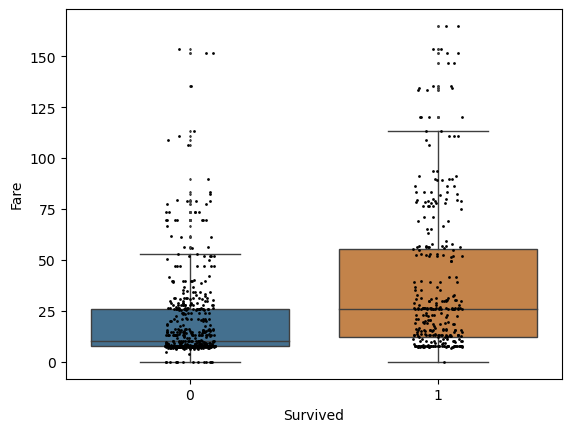

In [563]:
# Visualize features effect:
SELECTED_FEATURE = 'Fare'
sns.boxplot(x='Survived',y=SELECTED_FEATURE,data=df,saturation=0.5,linewidth=1,fliersize=1)
sns.stripplot(x='Survived',y=SELECTED_FEATURE,data=df,size=2,jitter=True,color='black')

<AxesSubplot:xlabel='Age', ylabel='Count'>

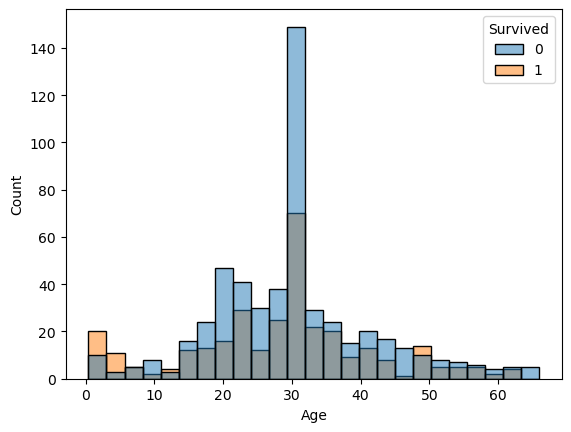

In [565]:
sns.histplot(data=df,x='Age',hue='Survived')

<AxesSubplot:xlabel='Sex', ylabel='count'>

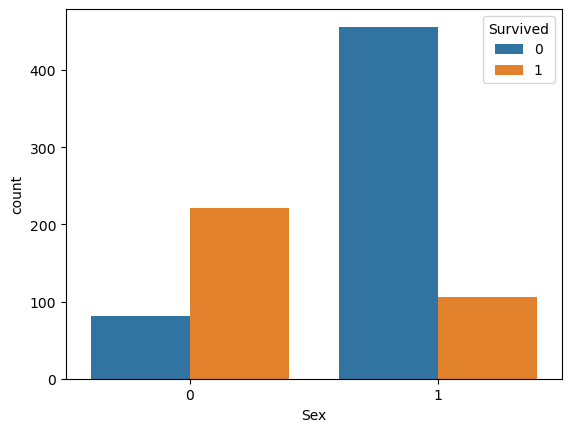

In [566]:
sns.countplot(x='Sex',hue='Survived',data=df)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

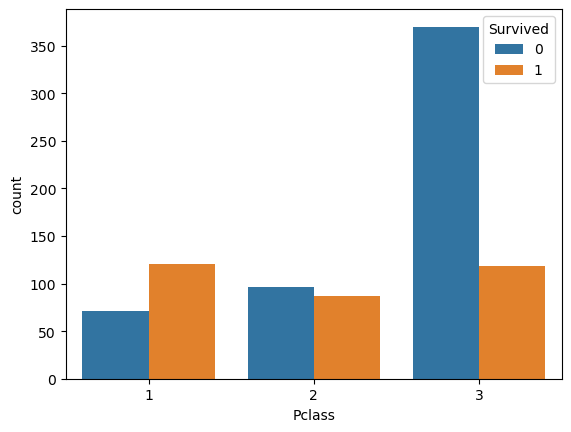

In [567]:
sns.countplot(x='Pclass',hue='Survived',data=df)

In [577]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.000000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.000000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.000000,3.0,3.0000
Sex,891.0,0.647587,0.477990,0.00,0.0000,1.000000,1.0,1.0000
Age,891.0,29.699118,13.002015,0.42,22.0000,29.699118,35.0,80.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.454200,31.0,512.3292
Embarked_C,891.0,0.188552,0.391372,0.00,0.0000,0.000000,0.0,1.0000
Embarked_Q,891.0,0.086420,0.281141,0.00,0.0000,0.000000,0.0,1.0000
Embarked_S,891.0,0.722783,0.447876,0.00,0.0000,1.000000,1.0,1.0000
SibSp_0,891.0,0.682379,0.465813,0.00,0.0000,1.000000,1.0,1.0000


In [570]:
# Train logistic regression model
#log_reg = LogisticRegression(max_iter=1000,penalty='l2',solver='lbfgs',C=0.1)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X=df[X],y=df[y])
df['survival_prediction'] = log_reg.predict(df[X])
df['survival_prediction_probability'] = [max(prob) for prob in log_reg.predict_proba(df[X])]
df.head(3)

/homes/sagic/.conda/envs/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,outlier,set,survival_prediction,survival_prediction_probability
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,False,train,0,0.880627
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C85,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,False,test,1,0.926787
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,NaN,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,False,train,1,0.570914


In [556]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X=df[X],y=df[y])
df['survival_prediction'] = knn.predict(df[X])
df['survival_prediction_probability'] = [max(prob) for prob in knn.predict_proba(df[X])]
df.head(3)

/homes/sagic/.conda/envs/py3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,outlier,set,survival_prediction,survival_prediction_probability
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,False,train,0,0.8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C85,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,False,train,1,0.6
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,NaN,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,False,train,0,0.8


In [571]:
TRAIN_DATA = len(df[df.set=='train'])
CORRECT_TRAIN = len(df[(df.set=='train')&(df.Survived == df.survival_prediction)])
TEST_DATA = len(df[df.set=='test'])
CORRECT_TEST = len(df[(df.set=='test')&(df.Survived == df.survival_prediction)])

MALE_TRAIN_DATA = len(df[(df.set=='train')&(df.Sex==1)])
FEMALE_TRAIN_DATA = len(df[(df.set=='train')&(df.Sex==0)])
MALE_TRAIN_CORRECT_PREDICTIONS = len(df[(df.set=='train')&(df.Survived == df.survival_prediction)&(df.Sex==1)])
FEMALE_TRAIN_CORRECT_PREDICTIONS = len(df[(df.set=='train')&(df.Survived == df.survival_prediction)&(df.Sex==0)])

MALE_TEST_DATA = len(df[(df.set=='test')&(df.Sex==1)])
FEMALE_TEST_DATA = len(df[(df.set=='test')&(df.Sex==0)])
MALE_TEST_CORRECT_PREDICTIONS = len(df[(df.set=='test')&(df.Survived == df.survival_prediction)&(df.Sex==1)])
FEMALE_TEST_CORRECT_PREDICTIONS = len(df[(df.set=='test')&(df.Survived == df.survival_prediction)&(df.Sex==0)])

print(f'Overall Accuracy: Test={CORRECT_TRAIN/TRAIN_DATA}; Train={CORRECT_TEST/TEST_DATA}')
print(f'Male Accuracy: Test={MALE_TEST_CORRECT_PREDICTIONS/MALE_TEST_DATA}; Train={MALE_TRAIN_CORRECT_PREDICTIONS/MALE_TRAIN_DATA}')
print(f'Female Accuracy: Test={FEMALE_TEST_CORRECT_PREDICTIONS/FEMALE_TEST_DATA}; Train={FEMALE_TRAIN_CORRECT_PREDICTIONS/FEMALE_TRAIN_DATA}')

Overall Accuracy: Test=0.8055077452667814; Train=0.8268551236749117
Male Accuracy: Test=0.8235294117647058; Train=0.8188775510204082
Female Accuracy: Test=0.831858407079646; Train=0.7777777777777778
